# Notebook 2) Exploratory Data Analysis & Cohort Definition

This notebook performs the analysis required for both the inference model (Notebook 3) and the machine-learning wage predictor model (Notebook 4).  
Its purpose is to check the quality of the **raw CPS data**, identify **key drivers of wages**, and define a **clean and consistent modelling cohort**.


The structure of this EDA follows the classical labour-economics approach used in Blau & Kahn (2017):
- (1) Document the distribution of log hourly wages and the raw gender gap,
- (2) characterise how men and women are distributed across education, occupations, industries and hours, and
- (3) prepare a clean modelling cohort and feature set.


Concretely, it will:

1. **Audit the raw CPS table (`cps_raw`) via SQL**
   - Check sample size, year coverage and basic structure  
   - Verify wage, hours and key demographic fields  
   - Identify structural missingness and impossible values  

2. **Measure the unadjusted gender pay gap**
   - Overall  
   - By age, education, occupation and industry  

3. **Characterise the labour-market structure**
   - Gender composition by occupation and industry  
   - Distribution of education, hours and demographic groups  

4. **Define cohort inclusion rules**
   - Filters for valid wages, hours, demographics, occupation and industry dummies  
   - Decision to hold out the latest year as test data  

5. **Select the final predictor set**
   - Remove redundant variables  
   - Keep relevant features for inference (Notebook 3) and ML (Notebook 4)


## Outputs

By the end of this notebook we have:

- A documented description of the CPS wage structure  
- The raw gender pay gap across main subgroups  
- Evidence that the latest year behaves like previous years and can be used as the test set  
- Explicit data-quality decisions (dropped variables, handled missingness, kept outliers)  
- A specified feature set and cohort definition, implemented in SQL as the view `vw_model_cohort`.

This notebook therefore acts as the **bridge** between raw data and the modeling stage.


## Table of Contents

- [1) Problem statement & data assessment](#1-problem-statement--data-assessment)
- [2) Imports and Setup](#2-imports-and-setup)
- [3) Raw CPS overview (from SQL)](#3-raw-cps-overview-from-sql)
  - [3.1) Size and preview of first rows](#31-size-and-preview-of-first-rows)
  - [3.2) Year range: min and max year](#32-year-range-min-and-max-year)
  - [3.3) Gender distribution](#33-gender-distribution)
  - [3.4) Basic wage check](#34-basic-wage-check)
- [4) Data quality, key variables & group structure](#4-data-quality-key-variables--group-structure)
  - [4.1) Key variables](#41-key-variables)
  - [4.2) Missingness & impossible values](#42-missingness--impossible-values)
    - [4.2.1) Null values assessment](#421-null-values-assessment)
    - [4.2.2) Impossible values](#422-impossible-values)
  - [4.3) Redundancy check](#43-redundancy-check)
    - [4.3.1) Wage variables](#431-wage-variables)
    - [4.3.2) Education and experience variables](#432-education-and-experience-variables)
    - [4.3.3) Hours worked variables](#433-hours-worked-variables)
  - [4.4) Group imbalance](#44-group-imbalance)
- [5) Univariate Analysis (Descriptive statistics)](#5-univariate-analysis-descriptive-statistics)
  - [5.1) Numerical Variables](#51-numerical-variables)
    - [5.1.1) Descriptive Stats](#511-descriptive-stats)
    - [5.1.2) Distribution](#512-distribution)
    - [5.1.3) Outlier Analysis](#513-outlier-analysis)
  - [5.2) Categorical Variables](#52-categorical-variables)
    - [5.2.1) Mapping encoded variables for visualization](#521-mapping-encoded-variables-for-visualization)
    - [5.2.2) Value Counts and Visualization](#522-value-counts-and-visualization)
    - [5.2.4) Education Distribution (Detailed Subsection)](#524-education-distribution-detailed-subsection)
  - [5.3) Dummy Variables (Occupation & Industry)](#53-dummy-variables-occupation--industry)
    - [5.3.1) Occupation](#531-occupation)
    - [5.3.2) Industry](#532-industry)
- [6) Bivariate Analysis: gender pay gap](#6-bivariate-analysis-gender-pay-gap)
  - [6.1) Overall gap (no controls)](#61-overall-gap-no-controls)
  - [6.2) Wage Gap by Age](#62-wage-gap-by-age)
  - [6.3) Wage Gap by education](#63-wage-gap-by-education)
  - [6.4) Wage gap by occupation and industry](#64-wage-gap-by-occupation-and-industry)
    - [6.4.1) Occupation](#641-occupation)
    - [6.4.2) Industry](#642-industry)
  - [6.5) Correlation Matrix](#65-correlation-matrix)
- [7) Temporal Patterns](#7-temporal-patterns)
  - [7.1) Year-level summary: size, wages, hours](#71-year-level-summary-size-wages-hours)
  - [7.2) Mean log wage over time (overall)](#72-mean-log-wage-over-time-overall)
  - [7.3) Mean log wage over time by sex](#73-mean-log-wage-over-time-by-sex)
- [8) Data Quality Decisions & Exclusions](#8-data-quality-decisions--exclusions)
- [9) Cohort Rules & Predictor Set (Hand-off to SQL)](#9-cohort-rules--predictor-set-hand-off-to-sql)
  - [9.1) Cohort definition (who is included)](#91-cohort-definition-who-is-included)
  - [9.2) Final cohort selection](#92-final-cohort-selection)
- [10) EDA conclusions (summary for modelling)](#10-eda-conclusions-summary-for-modelling)


# 1) Problem statement & data assessment

**Business goal.**  
EquityLens is a diagnostic and planning tool to help organisations check whether women are being paid fairly and, if not, plan how to fix it with a realistic budget. The tool uses the US Current Population Survey (CPS) as a public proxy for “market pay”, learning what a gender-blind pay level looks like for each job-related features.

**Technical context.**  
In Notebook 1, the CPS CSV file was loaded into a SQLite database at `../data/sql_cps_database.db` as a raw table `cps_raw`. That table preserves the original CPS structure (one row per person, many columns, minimal cleaning).

**What this notebook does.**

- Inspect `cps_raw` directly from SQLite to understand size, years covered, and basic structure.
- Focus on variables that matter for hourly wages and the gender pay gap (wages, hours, demographics, education, occupation, industry).
- Quantify the raw gender gap and how it varies across groups.
- Identify data quality issues (missingness, implausible values, small groups).
- Define **transparent cohort rules** and a **predictor set** that will be encoded in SQL as a view `vw_model_cohort` in `01_load_curate.sql`.

# 2) Imports and Setup

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

In [5]:
warnings.filterwarnings("ignore", category=FutureWarning)

db_path = "../data/sql_cps_database.db"

conn = sqlite3.connect(db_path)

with open("../sql/01_load_curate.sql") as f:
    conn.executescript(f.read())

The database connection was successful, and the expected table cps_raw is present. This confirms that the data ingestion in Notebook 1 worked correctly, and the raw CPS dataset is ready for direct SQL-based exploration.

# 3) Raw CPS overview (from SQL)

## 3.1) Size and preview of first rows

In [6]:
row_count = pd.read_sql("SELECT COUNT(*) AS n_rows FROM cps_raw", conn)
print("Total rows in cps_raw: ")
display (row_count)

peek = pd.read_sql("SELECT * FROM cps_raw LIMIT 5", conn)
print("Preview of cps_raw (first 5 rows):")
display(peek)

print("Number of columns:", peek.shape[1])

Total rows in cps_raw: 


,n_rows
0,344287


Preview of cps_raw (first 5 rows):


,year,serial,numprec,hwtsupp,gq,region,statefip,metro,metarea,county,...,foodcare,building,sales,officeadmin,farmer,constructextractinstall,production,transport_occ,sumadj_occ,LEHS
0,1990,9677,1,1052.650024,1,12,36,2.0,5607.0,None,...,0,0,0,1,0,0,0,0,1,1
1,2009,64923,4,971.200012,1,33,5,2.0,NaN,None,...,0,0,0,1,0,0,0,0,1,1
2,1990,8425,1,1622.280029,1,12,36,3.0,5607.0,None,...,0,0,0,0,0,0,0,0,1,1
3,1990,67963,1,2689.909912,1,42,6,3.0,7400.0,None,...,0,0,0,0,0,0,0,0,1,0
4,1981,38650,9,1911.900024,1,31,51,3.0,8840.0,None,...,0,0,0,0,0,0,0,0,1,1


Number of columns: 234


The raw CPS table contains 344287 rows. This confirms that the full dataset was successfully ingested.
The table contains 234 columns and it mixes raw identifiers, geography codes, wage measures, hours, demographics and the occupation/industry dummies.

## 3.2) Year range: min and max year

In [7]:
year_range = pd.read_sql("""
    SELECT 
    MIN(year) as min_year,
    MAX(year) as max_year,
    COUNT(*) AS n_rows
    FROM cps_raw;                         
""", conn)

print("Year coverage in cps_raw: ")
display(year_range)

year_counts = pd.read_sql("""
    SELECT year, COUNT(*) AS n_rows
    FROM cps_raw
    GROUP BY year
    ORDER BY year
""", conn)

print("Row distribution by year:")
display(year_counts)

Year coverage in cps_raw: 


,min_year,max_year,n_rows
0,1981,2013,344287


Row distribution by year:


,year,n_rows
0,1981,42379
1,1990,45033
2,1999,37144
3,2007,56467
4,2009,55617
5,2011,53857
6,2013,53790


#### Key Points:

The dataset covers seven years between 1981 and 2013 and each year has a large sample (roughly 37k–56k rows).

## 3.3) Gender distribution

In [8]:
sex_counts = pd.read_sql("""
    SELECT 
        CASE WHEN sex = 1 THEN 'Male' ELSE 'Female' END as sex_label,
        COUNT(*) AS n_rows
    FROM cps_raw
    GROUP BY sex
""", conn)

print("Counts by sex (raw CPS):")
display(sex_counts)

Counts by sex (raw CPS):


,sex_label,n_rows
0,Male,175911
1,Female,168376


#### Key Points:

There is a similar number of men and women (about 176k men and 168k women), which gives us a balanced and unbiased sample.

## 3.4) Basic wage check

In [9]:
wage_check = pd.read_sql("""
    SELECT 
        CASE WHEN sex = 1 THEN 'Male' ELSE 'Female' END as sex_label,
        AVG(incwage) AS avg_wage
    FROM cps_raw
    GROUP BY sex
""", conn)

print("Raw average wage by sex:")
display(wage_check)

Raw average wage by sex:


,sex_label,avg_wage
0,Male,47729.860941
1,Female,31436.945960


#### Key Points:

Even before any cleaning or filtering, men already show higher average wages than women. This confirms that the raw CPS contains a visible gender pay gap, which we’ll quantify more rigorously after controlling for hours, education, occupation and other job factors.

# 4) Data quality, key variables & group structure

## 4.1) Key variables

To structure the EDA, I relied directly on the CPS official data dictionary that accompanies this dataset (`../data/data_dictionary.txt`).  
The raw dataset contains more than 230 variables, including data-quality flags, historical occupation and industry coding systems, and several duplicates of the same concepts. Most of these do not contribute to understanding wages or the gender gap. A focused subset is therefore selected so that every variable used in the EDA has clear meaning and relevance.

Below are the variables retained for EDA, all taken directly from the CPS data dictionary and grouped into the categories most relevant for wage analysis.

### Wage & Earnings

- ```incwage``` : Wage and salary income (annual).
- ```hrwage``` : Hourly wage.
- ```realhrwage``` : Real hourly wage, inflation-adjusted to 2010 dollars.
- ```lnrwg``` : log of real hourly wage (log-transformed `realhrwage`).


### Demographics

- ```sex``` : Sex (1 = male, 2 = female).
- ```age``` : Age.
- ```race``` : Race (White non-Hispanic = 1, Black non-Hispanic = 2, Hispanic = 3, Other non-Hispanic = 4).
- ```marst``` : Marital status (Married, spouse present = 1; Married, spouse absent = 2; Separated = 3; Divorced = 4; Widowed = 5; Never married = 6).



### Education & Human Capital

- ```sch``` : Educational attainment recode in years of schooling (None = 0, Grades 1–12, Some college = 13, Associate = 14, BA = 16, Advanced degree = 18).
- ```educ99``` : Educational attainment, 1990-based coding (1 = no school (...)18 = doctorate).
- ```ba``` : Bachelor’s degree dummy.
- ```adv``` : Advanced degree dummy.
- ```potexp``` : Potential experience = age – years of schooling – 6.
- ```potexp2``` : Potential experience squared.
- ```citizen``` : Citizenship status.
- ```nativity``` : Foreign birthplace or parentage.


### Job Characteristics

- ```uhrswork``` : Usual hours worked per week (in the year prior to survey).
- ```annhrs``` : Annual work hours.
- ```classwkr``` : Class of worker (Self-employed = 10; Private wage/salary = 21; Government = 24–28; Unpaid family worker = 29).
- ```union``` : Union membership (0 = NIU; 1 = no union coverage; 2 = member; 3 = covered but not a member).
- ```ft``` : Full-time work dummy.


### Time

- `year` : Survey year.


### Aggregated Industry Groups 

- `finance`, `medical`, `education`, `publicadmin`, `professional`,
  `durables`, `nondurables`, `retailtrade`, `wholesaletrade`,
  `transport_ind`, `utilities`, `communications`, `socartother`, 
  `hotelsrestaurants`, `agriculture`, `miningconstruction`


### Aggregated Occupation Groups

- `manager`, `business`, `financialop`, `computer`,  
  `architect`, `scientist`, `socialworker`,  
  `postseceduc`, `legaleduc`, `artist`,  
  `lawyerphysician`, `healthcare`, `healthsupport`,  
  `protective`, `foodcare`, `building`,  
  `sales`, `officeadmin`, `farmer`,  
  `constructextractinstall`, `production`, `transport_occ`

## 4.2) Missingness & impossible values

In [10]:
variables = [
    "incwage", "hrwage", "realhrwage", "lnrwg",
    "sex", "age", "race", "marst", "citizen", "nativity",
    "sch", "educ99", "ba", "adv", "potexp", "potexp2",
    "uhrswork", "annhrs", "classwkr", "union", "ft",
    "year", "northeast", "northcentral", "south", "west",
    "finance", "medical", "education", "publicadmin", "professional",
    "durables", "nondurables",
    "retailtrade", "wholesaletrade",
    "transport_ind", "utilities", "communications",
    "socartother", "hotelsrestaurants",
    "agriculture", "miningconstruction",
    "manager", "business", "financialop", "computer",
    "architect", "scientist", "socialworker",
    "postseceduc", "legaleduc", "artist",
    "lawyerphysician", "healthcare", "healthsupport",
    "protective", "foodcare", "building",
    "sales", "officeadmin", "farmer",
    "constructextractinstall", "production", "transport_occ"
]

q = ', '.join([f'"{col}"' for col in variables])

df = pd.read_sql(f"SELECT {q} FROM cps_raw", conn)
df.columns = df.columns.str.lower().str.replace('"', '', regex=False)
print("Number of Columns:", len(variables))

Number of Columns: 64


The 64 column's names are wrapped in double quotes in the query to avoid conflicts with SQL key word "union".

### 4.2.1) Null values assessment

In [11]:
nulls = df.isnull().sum().sort_values(ascending=False)
nulls_pct = (df.isnull().mean() * 100).round(2).sort_values(ascending=False)

missing_df = pd.DataFrame({
    "missing_count" : nulls,
    "missing_pct" : nulls_pct
})

display(missing_df)

,missing_count,missing_pct
citizen,299748,87.06
nativity,87824,25.51
educ99,87412,25.39
union,42379,12.31
manager,0,0.00
...,...,...
education,0,0.00
publicadmin,0,0.00
professional,0,0.00
durables,0,0.00


In [12]:
cols_to_drop_missing = ["citizen", "nativity"]

df = df.drop(columns=cols_to_drop_missing, errors="ignore")

#### Key Points:

- `citizen`: 87% missing.
- `nativity`: ~25% missing.

Because these gaps are large and not random, trying to analyse or model them would add unnecessary noise to the project. For these reasons, `citizen`and `nativity` were dropped.

Education missingness is around 25%. We retain these cases since missingness will be assessed through occupation/industry distributions and the log-wage target.

### 4.2.2) Impossible values

In [13]:
impossible_counts = pd.read_sql("""
    SELECT
        SUM(CASE WHEN incwage IS NULL OR incwage <= 0 THEN 1 ELSE 0 END) AS bad_wage,
        SUM(CASE WHEN uhrswork IS NULL OR uhrswork <= 0 THEN 1 ELSE 0 END) AS bad_hours,
        SUM(CASE WHEN age < 16 OR age > 80 THEN 1 ELSE 0 END) AS bad_age
    FROM cps_raw;
""", conn)

display(impossible_counts)

,bad_wage,bad_hours,bad_age
0,0,0,0


### Key Points:

The checks for impossible values showed no problems: wages are always positive, usual hours are above zero, and all individuals fall in the 16–80 age range. In other words, the core fields are clean.

## 4.3) Redundancy check

### 4.3.1) Wage variables

In [14]:
wage_corr = df[["incwage", "hrwage", "realhrwage", "lnrwg"]].corr()
display(wage_corr)

,incwage,hrwage,realhrwage,lnrwg
incwage,1.000000,0.043150,0.041855,0.672341
hrwage,0.043150,1.000000,0.999919,0.058852
realhrwage,0.041855,0.999919,1.000000,0.060668
lnrwg,0.672341,0.058852,0.060668,1.000000


#### Key Findings:

The four wage related variables show redundancy: 
- "realhrwage" and "hrwage" are almost identical (correlation of ≈ 1), so only one is needed. 
- "incwage" shows almost no correlation with hourly wage because annual earnings mix wage rates with variation in hours and weeks worked. This makes it noisy and unreliable, so it is not appropriate as a modelling target.
- "lnrwg" is  the log transformation of real hourly wage, behaving as expected. For modelling, only `"realhrwage"` and its log `"lnrwg"` will be kept.

### 4.3.2) Education and experience variables

In [15]:
education_corr = df[["sch", "educ99", "ba", "adv", "potexp", "potexp2"]].corr()
display(education_corr)

,sch,educ99,ba,adv,potexp,potexp2
sch,1.000000,0.968976,0.463525,0.569922,-0.191744,-0.183853
educ99,0.968976,1.000000,0.508449,0.527319,-0.183225,-0.175016
ba,0.463525,0.508449,1.000000,-0.183750,-0.151227,-0.137908
adv,0.569922,0.527319,-0.183750,1.000000,-0.091958,-0.088144
potexp,-0.191744,-0.183225,-0.151227,-0.091958,1.000000,0.973652
potexp2,-0.183853,-0.175016,-0.137908,-0.088144,0.973652,1.000000


#### Key Findings:

- `sch` vs `educ99`: These two schooling measures are nearly identical (corr ≈ 0.97). "educ99" is the more explicit coding, so we keep it and drop "sch".

- The degree dummies (`ba`, `adv`) are intentionally kept. They capture the wage jumps associated with completing a bachelor’s or advanced degree, jumps that the numeric education scale of `"educ99"` doesn't represent well on its own.

- `"potexp"` and `"potexp2"` are both kept. The squared term is required to model the non linear wage growth pattern: income rises quickly early in a career and slows down later.


### 4.3.3) Hours worked variables

In [16]:
hours_worked_corr = df[["uhrswork", "annhrs"]].corr()
display(hours_worked_corr)

,uhrswork,annhrs
uhrswork,1.000000,0.873667
annhrs,0.873667,1.000000


#### Key Findings:

The two hours measures correlate strongly (≈ 0.87), which is expected since people who usually work more weekly hours also tend to accumulate more annual hours. However, these capture different aspects of labour, so both variables are retained.

In [17]:
cols_to_drop = [
    "incwage",
    "hrwage",
    "sch"
]

df_eda = df.drop(columns=cols_to_drop)

## 4.4) Group imbalance

Gender distribution across occupations and industries is a major driver of the raw pay gap.
If women cluster in lower-paid roles or sectors, part of the observed gap reflects job composition, not within-job pay differences.
Measuring this distribution is therefore essential to distinguish structural vs within-occupation inequality.

In [18]:
occ_groups = [
    "manager", "business", "financialop", "computer",
    "architect", "scientist", "socialworker",
    "postseceduc", "legaleduc", "artist",
    "lawyerphysician", "healthcare", "healthsupport",
    "protective", "foodcare", "building",
    "sales", "officeadmin", "farmer",
    "constructextractinstall", "production", "transport_occ"
]


ind_groups = [
    "finance", "medical", "education", "publicadmin",
    "durables", "nondurables",
    "retailtrade", "wholesaletrade",
    "transport_ind", "utilities", "communications",
    "socartother", "hotelsrestaurants",
    "agriculture", "miningconstruction"
]

occ_counts = df_eda.groupby("sex")[occ_groups].sum().T
occ_counts.index.name = "occupation_group"
occ_counts.columns = ["male", "female"]
occ_counts["total"] = occ_counts["male"] + occ_counts["female"]
occ_counts["male_pct"] = (occ_counts["male"] / occ_counts["total"] * 100).round(2)
occ_counts["female_pct"] = (occ_counts["female"] / occ_counts["total"] * 100).round(2)
display(occ_counts)

ind_counts = df_eda.groupby("sex")[ind_groups].sum().T
ind_counts.index.name = "industry_group"
ind_counts.columns = ["male", "female"]
ind_counts["total"] = ind_counts["male"] + ind_counts["female"]
ind_counts["male_pct"] = (ind_counts["male"] / ind_counts["total"] * 100).round(2)
ind_counts["female_pct"] = (ind_counts["female"] / ind_counts["total"] * 100).round(2)
display(ind_counts)

,male,female,total,male_pct,female_pct
occupation_group,,,,,
manager,21450,14246,35696,60.09,39.91
business,3114,4213,7327,42.50,57.50
financialop,3187,4515,7702,41.38,58.62
computer,6058,2544,8602,70.43,29.57
architect,7641,1083,8724,87.59,12.41
scientist,2374,1602,3976,59.71,40.29
socialworker,2289,3736,6025,37.99,62.01
postseceduc,1867,1624,3491,53.48,46.52
legaleduc,4748,17807,22555,21.05,78.95


,male,female,total,male_pct,female_pct
industry_group,,,,,
finance,9108,14008,23116,39.40,60.60
medical,7585,31755,39340,19.28,80.72
education,11143,26509,37652,29.59,70.41
publicadmin,12228,9966,22194,55.10,44.90
durables,23571,8686,32257,73.07,26.93
nondurables,12311,7815,20126,61.17,38.83
retailtrade,16224,16450,32674,49.65,50.35
wholesaletrade,8201,3404,11605,70.67,29.33
transport_ind,11647,4013,15660,74.37,25.63


The CPS shows extremely strong occupational segregation. Some fields are almost exclusively male (construction, protective services, transportation-related occupations), while others are overwhelmingly female (healthcare support, office administration, food and personal care, medical professions). A few sectors such as sales and retail remain more balanced.

# 5) Univariate Analysis (Descriptive statistics)

## Descriptive Statistics + Distributions

## 5.1) Numerical Variables

### 5.1.1) Descriptive Stats

In [19]:
numeric_cols = ["realhrwage", "lnrwg", "uhrswork", "annhrs", "age", "potexp", "potexp2"]

In [20]:
numeric_cols_desc = df_eda[numeric_cols].describe().T
numeric_cols_desc["IQR"] = numeric_cols_desc["75%"] - numeric_cols_desc["25%"]

display(numeric_cols_desc)

,count,mean,std,min,25%,50%,75%,max,IQR
realhrwage,344287.0,22.886629,506.489695,2.000000,11.723004,17.698591,26.442308,294610.968750,14.719305
lnrwg,344287.0,2.875068,0.625738,0.693147,2.461553,2.873485,3.274965,12.593411,0.813412
uhrswork,344287.0,40.576252,9.820125,1.000000,40.000000,40.000000,41.000000,99.000000,1.000000
annhrs,344287.0,2013.196449,599.050382,1.000000,1924.000000,2080.000000,2080.000000,5148.000000,156.000000
age,344287.0,41.734364,10.415874,25.000000,33.000000,41.000000,50.000000,64.000000,17.000000
potexp,344287.0,21.863602,10.623558,1.000000,13.000000,21.000000,30.000000,46.000000,17.000000
potexp2,344287.0,590.876751,502.797216,1.000000,169.000000,441.000000,900.000000,2116.000000,731.000000


#### Key Findings:

- The raw hourly wage variable ("realhrwage") shows an extreme right-skew, with a long tail and very high variance, making it unsuitable as a modelling target. Its log-transformed version ("lnrwg"), by contrast, shows a much more stable and compact distribution, which justifies using it as the modelling target. 

- Hours behave as expected: weekly hours cluster around 40, and annual hours show wider dispersion due to variation in weeks worked.

- Age and experience variables also look consistent, with "potexp" and "potexp2" reflecting the typical concave earnings cycle.

### 5.1.2) Distribution

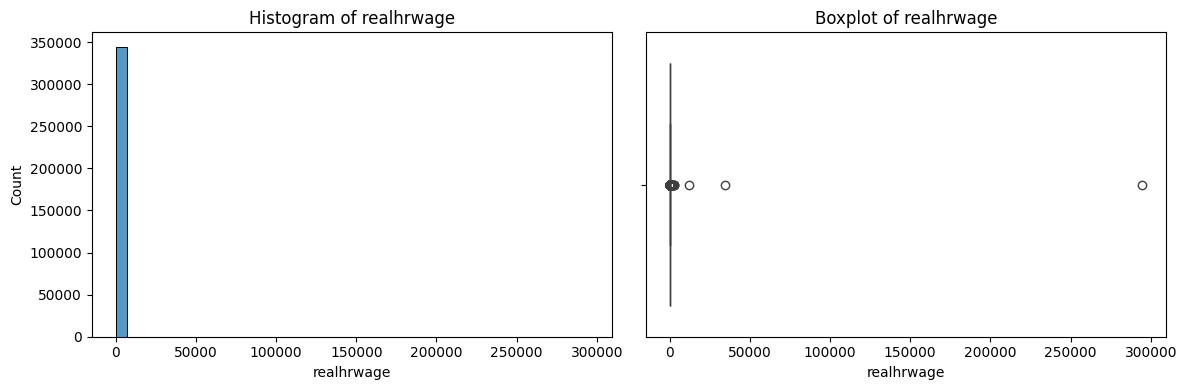

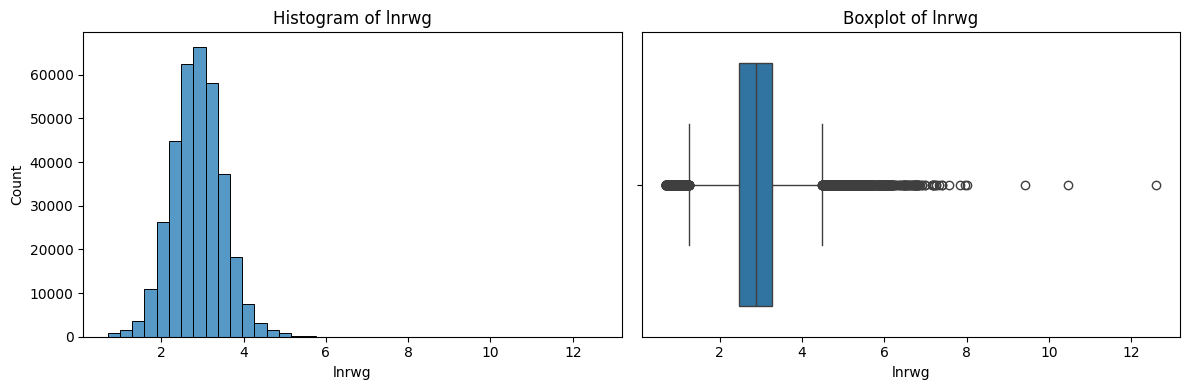

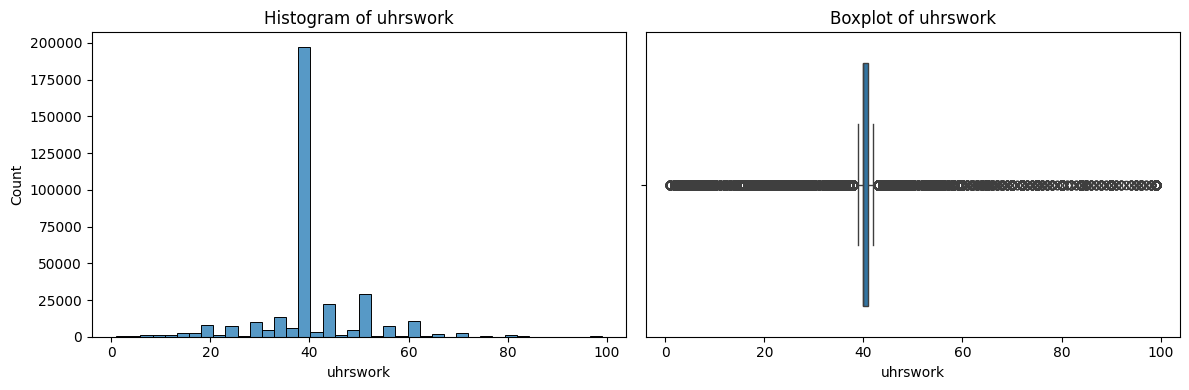

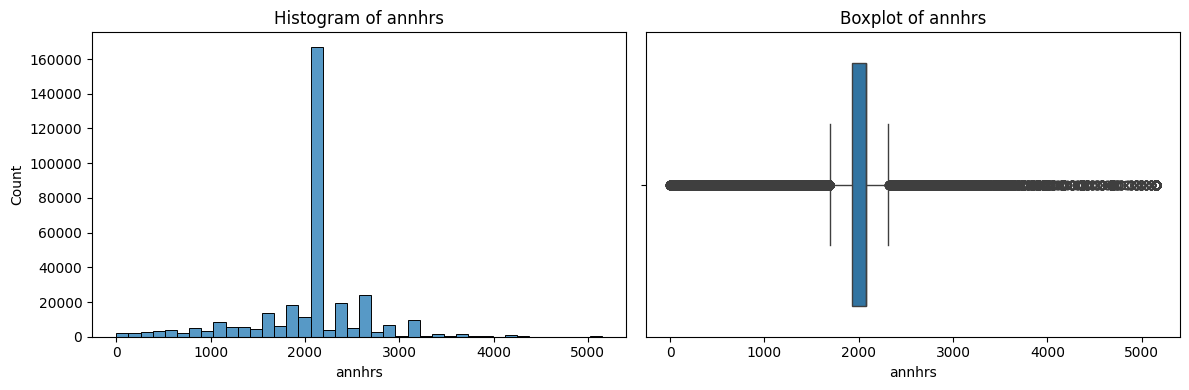

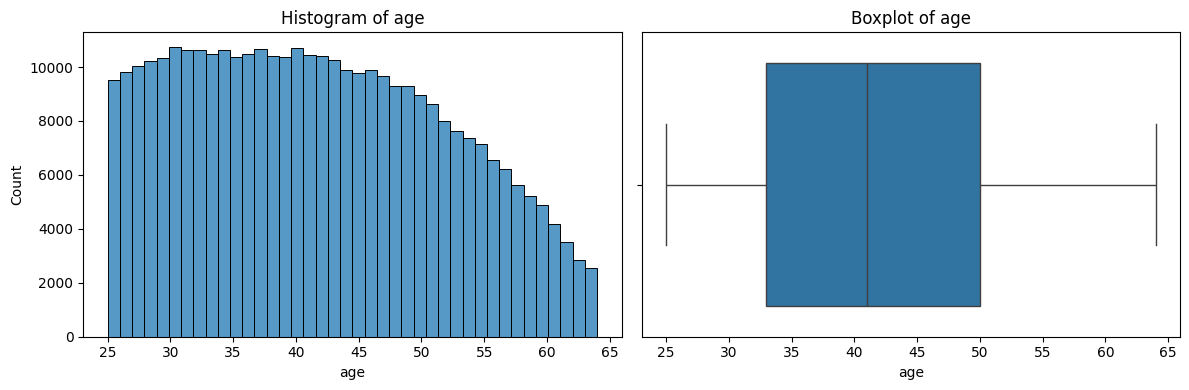

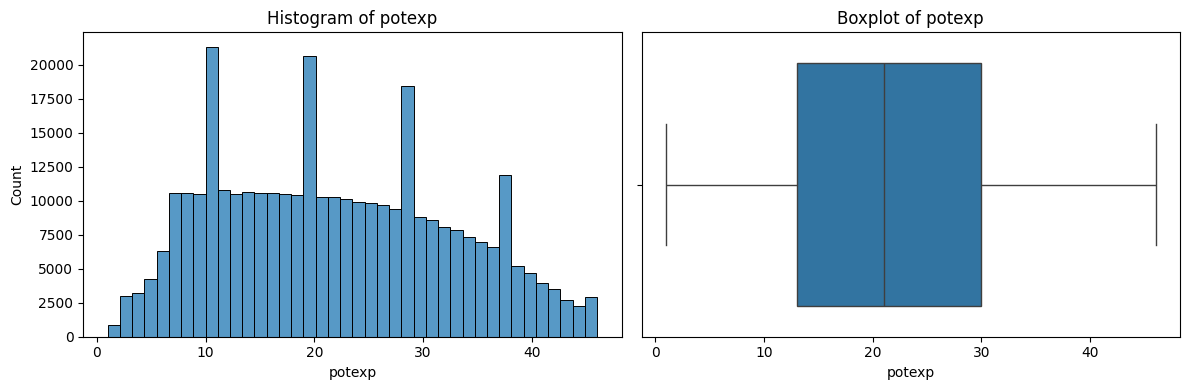

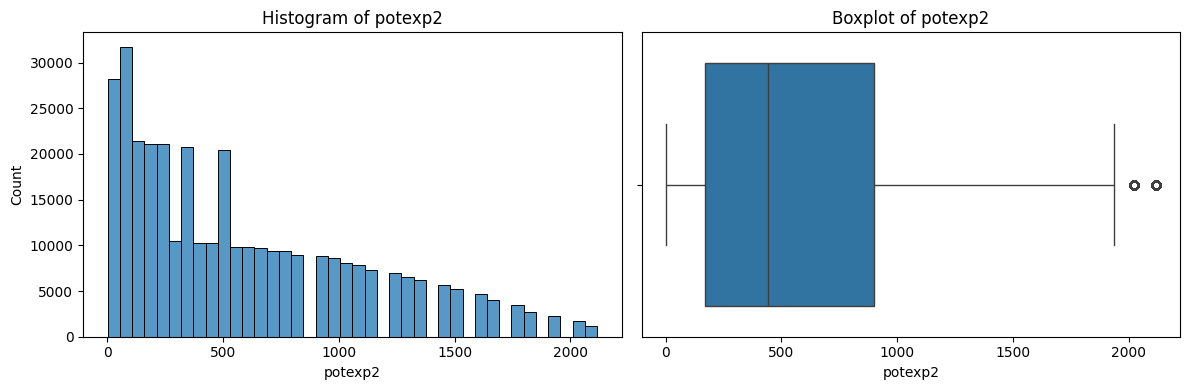

In [21]:
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df_eda[col], bins=40, ax=axes[0], kde=False)
    axes[0].set_title(f"Histogram of {col}")

    sns.boxplot(x=df_eda[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

#### Key Findings:

- **realhrwage** is extremely right-skewed, with rare but massive outliers (> $200k/hour), confirming it is unsuitable as a modelling target.

- **lnrwg**: the log transformed variable of "realhrwage" appears much more stable: the distribution becomes bell-shaped with only a mild right tail, making it the appropriate wage target.

- **uhrswork** shows the expected spike at 40 hours, with typical part-time and overtime patterns at the margins. 

- **annhrs**: most workers cluster around 2,000–2,100 hours (the full-time equivalent), with a right tail of very high annual hours.

- **age** is concentrated in the mid-20s to early-60s, consistent with a prime-age labour force.

- **potexp** (potential experience) and **potexp2** show the standard concave earnings profile (rapid growth early in career, flattening later).

### 5.1.3) Outlier Analysis

,iqr_lower,iqr_upper,% below lower,% above upper,min,max
0,1.24,4.5,0.628836,0.955308,0.693147,12.593411


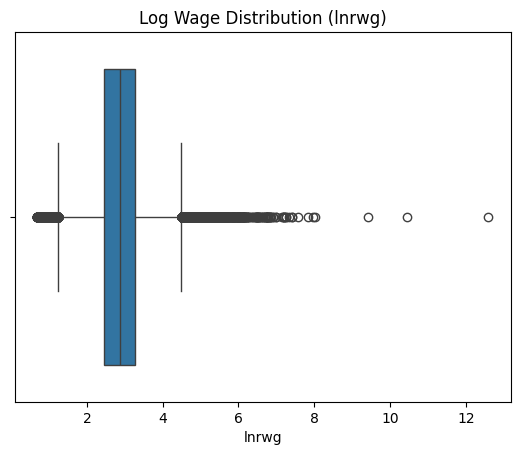

In [22]:
s = df_eda["lnrwg"].dropna()

q1, q3 = s.quantile([0.25, 0.75])
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outlier_summary = pd.DataFrame({
    "iqr_lower": [round(lower, 2)],
    "iqr_upper": [round(upper, 2)],
    "% below lower": [(s < lower).mean() * 100],
    "% above upper": [(s > upper).mean() * 100],
    "min": [s.min()],
    "max": [s.max()]
})

display(outlier_summary)

sns.boxplot(x=df_eda["lnrwg"])
plt.title("Log Wage Distribution (lnrwg)")
plt.show()

#### Key Analysis:

Outlier analysis is applied only to lnrwg, the modelling target. Raw wages, hours and age are not treated with IQR outlier rules because:

    - They are not errors but genuine labour-market heterogeneity.

    - IQR cut offs are meaningless for heavily right-skewed or bounded variables like hours or age.

Cohort filters handle the only meaningful quality constraints (e.g. annhrs ≥ uhrswork, age ≥ 16, non-zero hours).

The log-wage distribution is well-behaved, with <1% of observations in the extreme tails. No trimming or winsorisation is applied, as log transformation already stabilises the influence of high earners.

## 5.2) Categorical Variables 

In [23]:
categorical_cols = ["sex", "race", "marst", "educ99", "ba", "adv", "classwkr", "union", "ft", "year"]

### 5.2.1) Mapping encoded variables for visualization

In [24]:
df_eda["sex_label"] = df_eda["sex"].map({
    1: "Male",
    2: "Female"
})


df_eda["race_label"] = df_eda["race"].map({
    1: "White non-Hispanic",
    2: "Black non-Hispanic",
    3: "Hispanic",
    4: "Other non-Hispanic"
})


df_eda["marst_label"] = df_eda["marst"].map({
    1: "Married, spouse present",
    2: "Married, spouse absent",
    3: "Separated",
    4: "Divorced",
    5: "Widowed",
    6: "Never married"
})


educ99_map = {
    1: "No schooling",
    4: "1st–4th grade",
    5: "5th–8th grade",
    6: "9th grade",
    7: "10th grade",
    8: "11th grade",
    9: "12th, no diploma",
    10: "High school graduate",
    11: "Some college",
    13: "Associate (occupational)",
    14: "Associate (academic)",
    15: "Bachelor’s",
    16: "Master’s",
    17: "Professional degree",
    18: "Doctorate"
}
df_eda["educ99_label"] = df_eda["educ99"].map(educ99_map)


df_eda["classwkr_label"] = df_eda["classwkr"].map({
    10: "Self-employed",
    21: "Private wage/salary",
    24: "Federal gov",
    25: "State gov",
    26: "Local gov",
    27: "Armed forces",
    28: "Other gov",
    29: "Unpaid family worker"
})


df_eda["union_label"] = df_eda["union"].map({
    0: "NIU",
    1: "No union coverage",
    2: "Union member",
    3: "Covered, not member"
})
df_eda["union_label"] = df_eda["union_label"].fillna("Missing")

df_eda["ft_label"] = df_eda["ft"].map({
    0: "Not full-time",
    1: "Full-time"
})

### 5.2.2) Value Counts and Visualization

In [25]:
categ_cols_stats = ["sex_label", "race_label", "marst_label", "classwkr_label", "union_label", "ft_label", "year"]


    sex_label    


,count,pct
sex_label,,
Male,175911,51.09
Female,168376,48.91


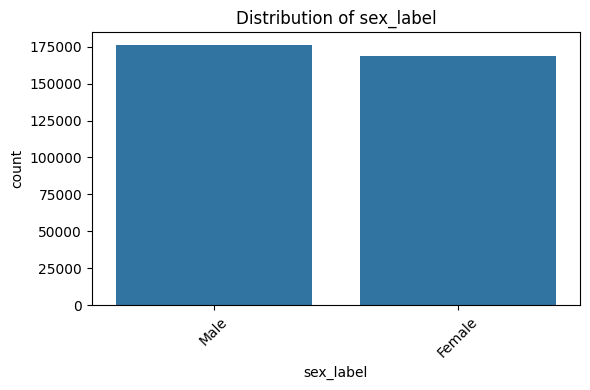


    race_label    


,count,pct
race_label,,
White non-Hispanic,240382,69.82
Hispanic,49283,14.31
Black non-Hispanic,33081,9.61
Other non-Hispanic,21541,6.26


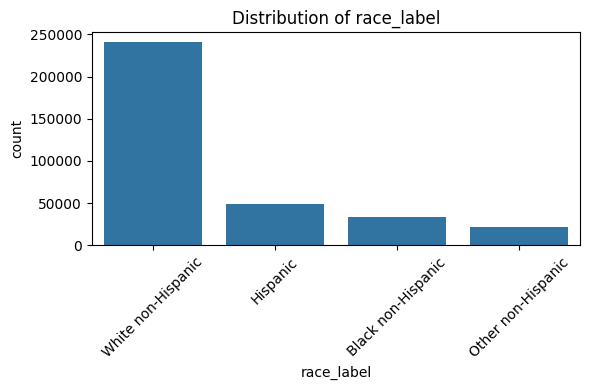


    marst_label    


,count,pct
marst_label,,
"Married, spouse present",229382,66.63
Never married,57293,16.64
Divorced,38830,11.28
Separated,8767,2.55
Widowed,5683,1.65
"Married, spouse absent",4332,1.26


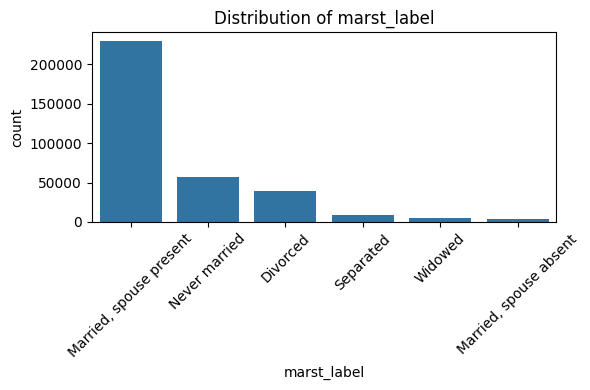


    classwkr_label    


,count,pct
classwkr_label,,
Private wage/salary,276071,80.19
Other gov,30134,8.75
Armed forces,17312,5.03
State gov,11103,3.22
Federal gov,9308,2.70
Self-employed,232,0.07
Unpaid family worker,127,0.04


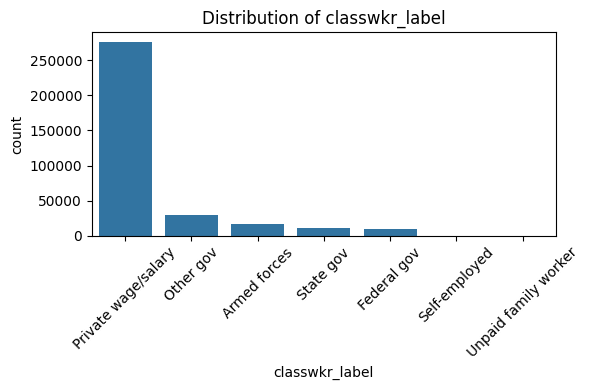


    union_label    


,count,pct
union_label,,
NIU,245732,71.37
No union coverage,46441,13.49
Missing,42379,12.31
Union member,8772,2.55
"Covered, not member",963,0.28


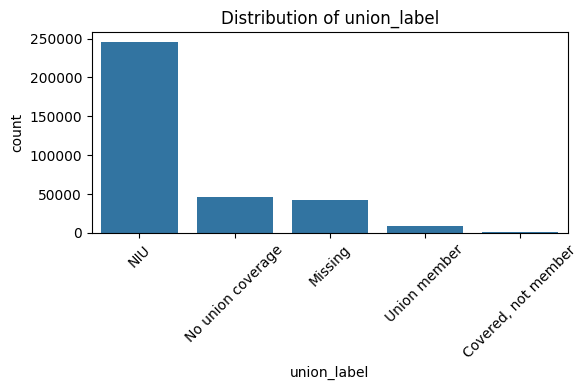


    ft_label    


,count,pct
ft_label,,
Full-time,302100,87.75
Not full-time,42187,12.25


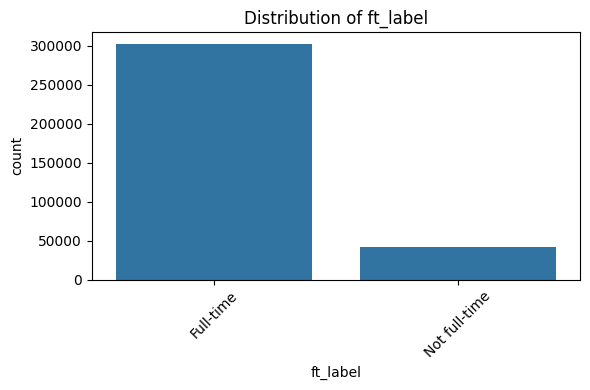


    year    


,count,pct
year,,
2007,56467,16.40
2009,55617,16.15
2011,53857,15.64
2013,53790,15.62
1990,45033,13.08
1981,42379,12.31
1999,37144,10.79


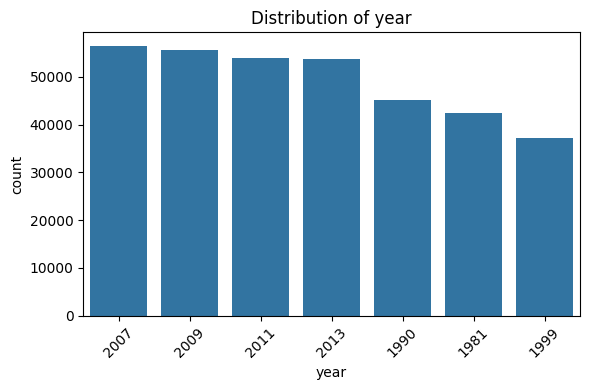

In [26]:
for col in categ_cols_stats:
    print(f"\n    {col}    ")
    counts = df_eda[col].value_counts(dropna=False)
    pct = (counts / counts.sum() * 100).round(2)

    summary = pd.DataFrame({"count": counts, "pct": pct})
    display(summary)

    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df_eda, order=counts.index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Key Findings (Categorical Variables):

#### `Gender`

As checked before, univariate analysis confirms the dataset is almost perfectly balanced (≈51% men, 49% women).

#### `Race`

The racial composition follows expected CPS patterns:

- White non-Hispanic workers dominate (≈70%),

- Hispanic (~14%) and Black non-Hispanic (~10%) groups are large enough for analysis

- “Other” (~6%) is small but still analytically usable.


#### `Marital Status`

Marital status is heavily skewed:

- The majority are “Married, spouse present” (≈67%).

- “Never married” (~17%) represents the second largest group.

- Divorced, separated, and widowed together form around 15%.


#### `Class of Worker`

Private-sector employment dominates (≈80%), with government employment split across smaller state and local categories. Self-employed and unpaid family workers show little representation.
This concentration implies that wage variation is strongly driven by private-sector roles, not institutional ones.


#### `Union Status`

As seen in the "Missingness" section, 12.3% of rows have union missing and NIU represents ≈81%.


#### `Full-Time / Part-Time`

Full-time workers dominate the dataset (~88%), confirming that this dataset captures the core labour market rather than temporary employment. Part-time workers form a small but relevant minority.


#### `Year`

All survey years are well represented (37k–56k observations per year).


### 5.2.4) Education Distribution (Detailed Subsection)

Numeric summary of educ99 (coded education levels):


count    256875.000000
mean         12.175689
std           3.003724
min           1.000000
25%          10.000000
50%          11.000000
75%          15.000000
max          18.000000
Name: educ99, dtype: float64

Education distribution (educ99_label):


,count,pct
educ99_label,,
NaN,87412,25.39
High school graduate,71373,20.73
Bachelor’s,58118,16.88
Some college,44811,13.02
Master’s,23881,6.94
Associate (academic),14809,4.30
Associate (occupational),13696,3.98
5th–8th grade,6507,1.89
11th grade,4336,1.26


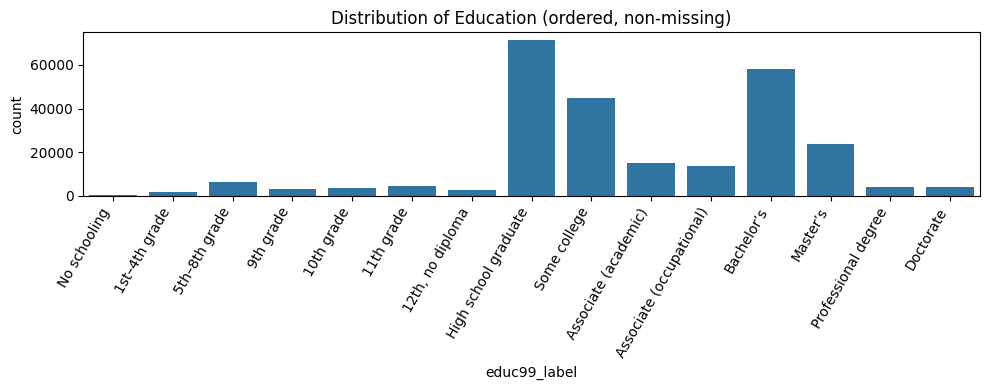

Overall BA rate:  21.2%
Overall ADV rate: 11.2%
BA and Advanced Degree Attainment by Sex:


,BA (%),Advanced (%)
sex_label,,
Female,21.86,11.12
Male,20.56,11.19


In [27]:
educ99_desc = df_eda["educ99"].describe()
print("Numeric summary of educ99 (coded education levels):")
display(educ99_desc)



educ_order = [
    "No schooling",
    "1st–4th grade",
    "5th–8th grade",
    "9th grade",
    "10th grade",
    "11th grade",
    "12th, no diploma",
    "High school graduate",
    "Some college",
    "Associate (academic)",
    "Associate (occupational)",
    "Bachelor’s",
    "Master’s",
    "Professional degree",
    "Doctorate",
]

educ_nonmiss = df_eda[df_eda["educ99_label"].notna()]


educ_counts = df_eda["educ99_label"].value_counts(dropna=False) 
educ_pct = (educ_counts / educ_counts.sum() * 100).round(2) 
educ_table = pd.DataFrame({ "count": educ_counts, "pct": educ_pct }) 
print("Education distribution (educ99_label):") 
display(educ_table)



plt.figure(figsize=(10, 4))
sns.countplot(
    x="educ99_label",
    data=educ_nonmiss,
    order=[lvl for lvl in educ_order if lvl in educ_nonmiss["educ99_label"].unique()]
)
plt.title("Distribution of Education (ordered, non-missing)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()




ba_rate = df_eda["ba"].mean()
adv_rate = df_eda["adv"].mean()

print(f"Overall BA rate:  {ba_rate*100:.1f}%")
print(f"Overall ADV rate: {adv_rate*100:.1f}%")



edu_by_sex = df_eda.groupby("sex_label")[["ba", "adv"]].mean() * 100
edu_by_sex = edu_by_sex.round(2)
edu_by_sex.columns = ["BA (%)", "Advanced (%)"]

print("BA and Advanced Degree Attainment by Sex:")
display(edu_by_sex)


#### Key Findings:

The CPS dataset displays strong educational variation, but a small number of categories dominate. 

- Around 25% of workers have missing educ99 (these cases are retained and treated as “unknown education”). The non-missing sample (~257k) is large enough to support a stable analysis.

- Among reported categories, high-school graduates (~21%), Bachelor’s (~17%), and some college (~13%) are the major groups. Graduate degrees collectively represent ~9%. Lower schooling levels (<8th grade) are rare (<2%), confirming a workforce concentrated in mid to high education.

- The BA attainment rate is 21.2%, and advanced degrees (Master’s/Professional/Doctorate) represent 11.2% of the entire workforce. 
    
`Gender differences are minimal (women slightly exceed men in BA attainment, and advanced-degree rates are nearly identical), so education alone cannot explain the gender wage gap.`

## 5.3) Dummy Variables (Occupation & Industry)

### 5.3.1) Occupation 

In [28]:
occ_freq = pd.DataFrame({
    "n_workers": df_eda[occ_groups].sum(),
})
occ_freq["share_pct"] = (occ_freq["n_workers"] / len(df_eda) * 100).round(2)
occ_freq = occ_freq.sort_values("share_pct", ascending=False)

print("Occupation group frequencies (one dummy = main occupation group):")
display(occ_freq)

Occupation group frequencies (one dummy = main occupation group):


,n_workers,share_pct
officeadmin,50635,14.71
manager,35696,10.37
constructextractinstall,30579,8.88
sales,30317,8.81
production,29732,8.64
legaleduc,22555,6.55
transport_occ,21277,6.18
foodcare,20845,6.05
healthcare,17684,5.14
building,12250,3.56


#### Key Findings:

The CPS labour market is strongly concentrated in a few occupations: office administration (14.7%), management (10.4%), construction/extraction/installation (8.9%), sales (8.8%) and production (8.6%). These five groups account for over half of all workers and therefore drive most wage patterns.

Mid-sized groups such as legal/education, transport, food services, etc. contribute between 3–7%, large enough for stable gender comparisons.

The remaining specialist categories (e.g., computer, architects, scientists) are all small (1–2.5%). They remain usable for modelling but are too small for strong group conclusions.

Overall, the CPS shows a highly concentrated occupational structure, with many groups represented sparsely.

### 5.3.2) Industry

In [29]:
ind_freq = pd.DataFrame({
    "n_workers": df_eda[ind_groups].sum(),
})
ind_freq["share_pct"] = (ind_freq["n_workers"] / len(df_eda) * 100).round(2)
ind_freq = ind_freq.sort_values("share_pct", ascending=False)

print("Industry group frequencies (one dummy = main industry group):")
display(ind_freq)


Industry group frequencies (one dummy = main industry group):


,n_workers,share_pct
medical,39340,11.43
education,37652,10.94
retailtrade,32674,9.49
durables,32257,9.37
socartother,24399,7.09
finance,23116,6.71
miningconstruction,22368,6.50
publicadmin,22194,6.45
nondurables,20126,5.85
hotelsrestaurants,16792,4.88


#### Key Findings:

The CPS labour market is unevenly distributed across industries, with a small number of sectors dominating the sample.

- Medical (11.43%) and Education (10.94%) are the two most present industries, together representing more than 22% of all workers.

- Mid-sized sectors (Retail Trade, Durable Manufacturing, Finance, Construction/Mining, and Public Administration) each contribute 5–10% of the workforce.

- Smaller industries such as Communications, Utilities, and Agriculture account for under 3% of workers.

# 6) Bivariate Analysis: gender pay gap

## 6.1) Overall gap (no controls)

In [47]:
def gender_gap(df, show_table=True):
    gap = df.groupby("sex_label")["lnrwg"].agg(["mean", "median"])
    gap["real_mean_wage"] = np.exp(gap["mean"])
    gap["real_median_wage"] = np.exp(gap["median"])
    display(gap)

    mean_m = gap.loc["Male", "mean"]
    mean_f = gap.loc["Female", "mean"]

    ratio = np.exp(mean_m - mean_f)
    ratio_pct = (ratio - 1) * 100

    return {"gap_pct": ratio_pct, "ratio": ratio}

overall_gap = gender_gap(df_eda)

print(f'Raw gender wage gap: {overall_gap["gap_pct"]:.1f}% lower hourly wage for women')

,mean,median,real_mean_wage,real_median_wage
sex_label,,,,
Female,2.731752,2.717394,15.359777,15.140816
Male,3.012245,3.017891,20.332988,20.448120


Raw gender wage gap: 32.4% lower hourly wage for women


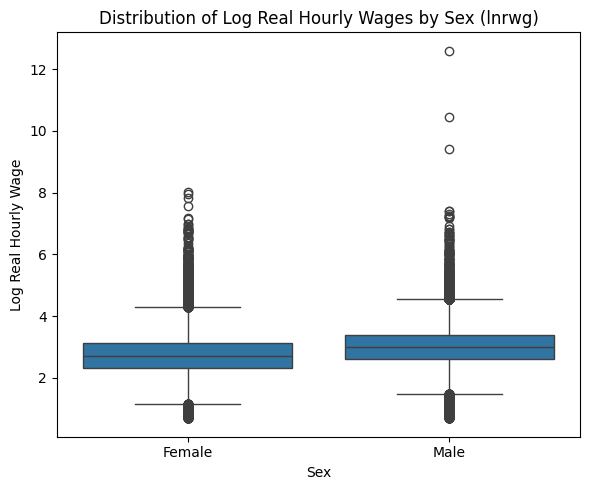

In [46]:
plt.figure(figsize=(6,5))
sns.boxplot(x="sex_label", y="lnrwg", data=df_eda, order=["Female", "Male"])
plt.title("Distribution of Log Real Hourly Wages by Sex (lnrwg)")
plt.xlabel("Sex")
plt.ylabel("Log Real Hourly Wage")
plt.tight_layout()
plt.show()

#### Key Analysis:

Women show a lower mean and median log hourly wage compared to men. 
- The mean is ≈ 2.73 for women and ≈ 3.01 for men, and the median follows the same pattern. 
- Exponentiating the mean log-wage difference gives a raw gap of 32.4%, meaning women earn about one-third less per hour on average.

The boxplot shows the same structure. The male distribution sits higher, with a higher median and a longer upper tail.

## 6.2) Wage Gap by Age

In [32]:
age_bins = [0, 29, 39, 49, 59, np.inf]
age_labels = ["<30", "30–39", "40–49", "50–59", "60+"]

df_eda = df_eda.copy()
df_eda["age_band"] = pd.cut(df_eda["age"], bins=age_bins, labels=age_labels)

age_sex_mean = (df_eda.groupby(["age_band", "sex_label"])["lnrwg"].mean().reset_index())

display(age_sex_mean)


age_gap = (age_sex_mean.pivot(index="age_band", columns="sex_label", values="lnrwg"))
age_gap["gap_pct"] = (np.exp(age_gap["Male"] - age_gap["Female"]) - 1) * 100

display(age_gap)

,age_band,sex_label,lnrwg
0,<30,Female,2.577585
1,<30,Male,2.715085
2,30–39,Female,2.726740
3,30–39,Male,2.976067
4,40–49,Female,2.775286
5,40–49,Male,3.118264
6,50–59,Female,2.783851
7,50–59,Male,3.124384
8,60+,Female,2.726366
9,60+,Male,3.051423


sex_label,Female,Male,gap_pct
age_band,,,
<30,2.577585,2.715085,14.740161
30–39,2.726740,2.976067,28.316143
40–49,2.775286,3.118264,40.913864
50–59,2.783851,3.124384,40.569678
60+,2.726366,3.051423,38.410889


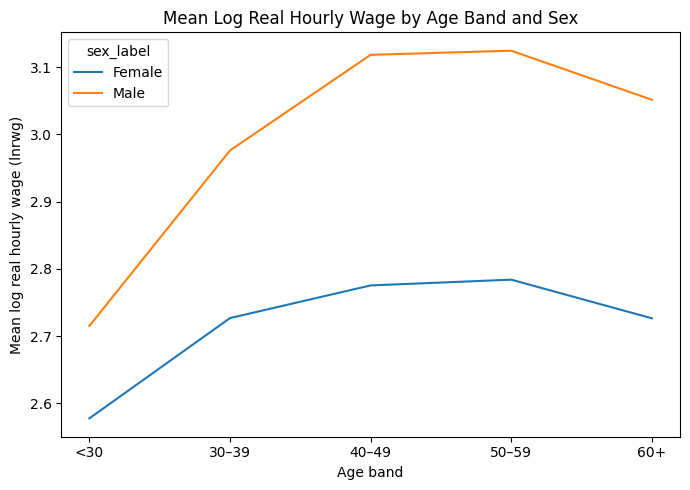

In [33]:
plt.figure(figsize=(7, 5))
sns.lineplot(
    data=age_sex_mean,
    x="age_band",
    y="lnrwg",
    hue="sex_label",
)
plt.title("Mean Log Real Hourly Wage by Age Band and Sex")
plt.xlabel("Age band")
plt.ylabel("Mean log real hourly wage (lnrwg)")
plt.tight_layout()
plt.show()

#### Key Analysis:

- Men earn more than women in every age band, and the gap widens sharply mid-career.

- The raw gap is ~15% below age 30, rises to ~28% at ages 30–39, and peaks at ~41% for ages 40–59.

- There is little convergence after age 60.

Women’s wage profile is flatter, while men’s rises substantially through mid-career.
The line chart shows a consistent vertical separation, largest in the 40–59 range.

## 6.3) Wage Gap by education

In [34]:
def education_bins(x):
    if x <= 10:
        return "HS or less"
    elif x <= 14:
        return "Some college"
    elif x == 15:
        return "Bachelor's"
    else:
        return "Advanced Degree"
    

df_eda = df_eda.copy()
df_eda["educ_bin"] = df_eda["educ99"].apply(education_bins)

educ_sex_mean = (df_eda.groupby(["educ_bin", "sex_label"])["lnrwg"].mean().reset_index())

display(educ_sex_mean)


educ_gap = (educ_sex_mean.pivot(index="educ_bin", columns="sex_label", values="lnrwg"))
educ_gap["gap_pct"] = (np.exp(educ_gap["Male"] - educ_gap["Female"]) - 1) * 100

display(educ_gap)


,educ_bin,sex_label,lnrwg
0,Advanced Degree,Female,2.746313
1,Advanced Degree,Male,3.090823
2,Bachelor's,Female,3.039304
3,Bachelor's,Male,3.308638
4,HS or less,Female,2.488308
5,HS or less,Male,2.758182
6,Some college,Female,2.736368
7,Some college,Male,3.007391


sex_label,Female,Male,gap_pct
educ_bin,,,
Advanced Degree,2.746313,3.090823,41.129899
Bachelor's,3.039304,3.308638,30.909121
HS or less,2.488308,2.758182,30.979916
Some college,2.736368,3.007391,31.130447


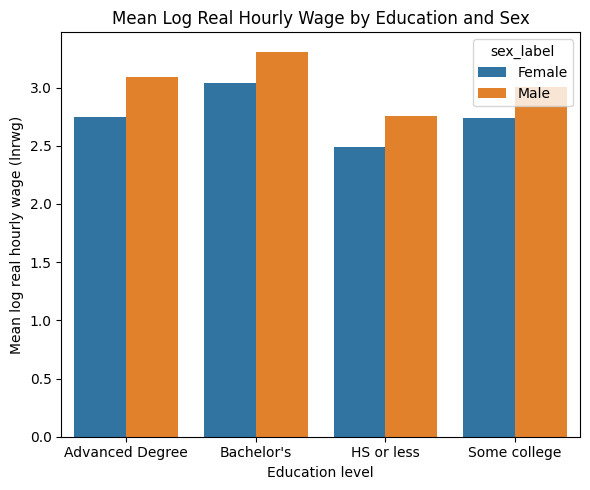

In [35]:
plt.figure(figsize=(6,5))
sns.barplot(
    data=educ_sex_mean,
    x="educ_bin",
    y="lnrwg",
    hue="sex_label"
)

plt.title("Mean Log Real Hourly Wage by Education and Sex")
plt.xlabel("Education level")
plt.ylabel("Mean log real hourly wage (lnrwg)")
plt.tight_layout()
plt.show()

#### Key Analysis:

Mean log hourly wages rise with education for both sexes, but men earn more at every level. The gap is:
- ~31% for high-school or less, 
- ~31% for some college, and 
- ~31% for bachelor’s degrees.
It increases further at the top: women with advanced degrees earn ~41% less than comparable men.

The bar chart confirms a consistent vertical separation, widest for advanced degrees.
`Higher education lifts wages, but does not reduce the gender gap.`

## 6.4) Wage gap by occupation and industry

### 6.4.1) Occupation

In [36]:
df_eda = df_eda.copy()
df_eda["occ"] = df_eda[occ_groups].idxmax(axis=1)

top_10_occ = (df_eda["occ"].value_counts().head(10).index)

occ_sex_mean = (df_eda[df_eda["occ"].isin(top_10_occ)]
                .groupby(["occ", "sex_label"])["lnrwg"].mean().reset_index())

display(occ_sex_mean)


occ_gap = (occ_sex_mean.pivot(index="occ", columns="sex_label", values="lnrwg"))
occ_gap["gap_pct"] = (np.exp(occ_gap["Male"] - occ_gap["Female"]) - 1) * 100

display(occ_gap)


,occ,sex_label,lnrwg
0,building,Female,2.229460
1,building,Male,2.511528
2,constructextractinstall,Female,2.791894
3,constructextractinstall,Male,2.924744
4,foodcare,Female,2.279684
5,foodcare,Male,2.461213
6,healthcare,Female,3.124293
7,healthcare,Male,3.223276
8,legaleduc,Female,2.824096
9,legaleduc,Male,3.056012


sex_label,Female,Male,gap_pct
occ,,,
building,2.229460,2.511528,32.586925
constructextractinstall,2.791894,2.924744,14.207919
foodcare,2.279684,2.461213,19.904980
healthcare,3.124293,3.223276,10.404708
legaleduc,2.824096,3.056012,26.101413
manager,3.101223,3.382685,32.506590
officeadmin,2.658573,2.876846,24.392660
production,2.421360,2.864278,55.724518
sales,2.568271,3.042959,60.751105


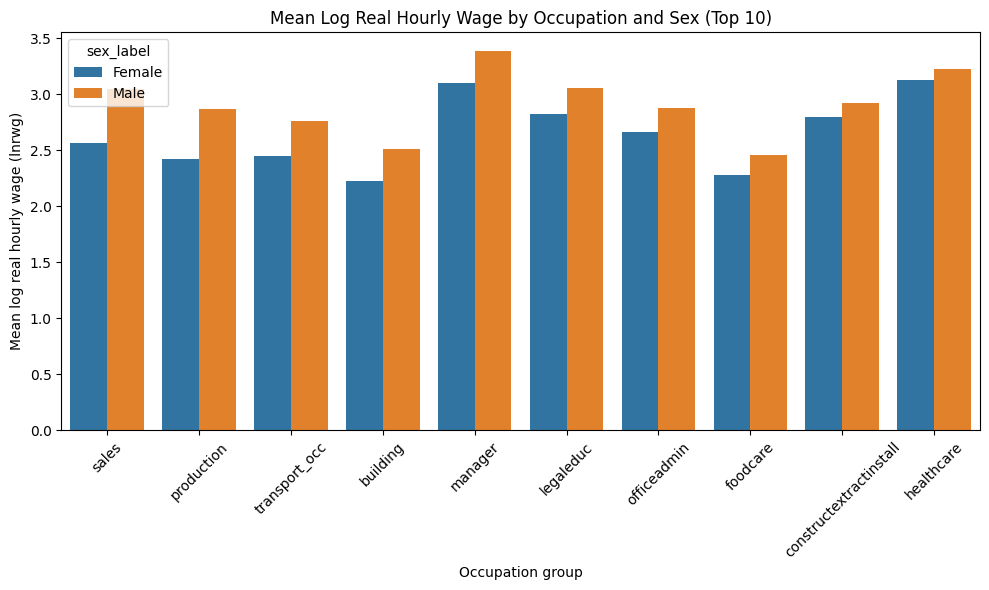

In [37]:
occ_order = (
    occ_gap
    .sort_values("gap_pct", ascending=False)
    .index
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=occ_sex_mean,
    x="occ",
    y="lnrwg",
    hue="sex_label",
    order=occ_order
)
plt.title("Mean Log Real Hourly Wage by Occupation and Sex (Top 10)")
plt.xlabel("Occupation group")
plt.ylabel("Mean log real hourly wage (lnrwg)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Key Analysis:

Across the ten largest occupation groups, men earn more than women in every case.
- The smallest gaps appear in healthcare (~10%) and construction/extraction (~14%), while the largest occur in sales (~61%) and production (~56%).

The bar chart shows a consistent vertical separation: the male distribution sits above the female one in all occupations, with the gap especially pronounced in sales, production, and transportation, and noticeably smaller in healthcare and construction.

### 6.4.2) Industry

In [38]:
df_eda = df_eda.copy()
df_eda["ind"] = df_eda[ind_groups].idxmax(axis=1)

top_10_ind = (df_eda["ind"].value_counts().head(10).index)

ind_sex_mean = (df_eda[df_eda["ind"].isin(top_10_ind)]
                .groupby(["ind", "sex_label"])["lnrwg"].mean().reset_index())

display(ind_sex_mean)


ind_gap = (ind_sex_mean.pivot(index="ind", columns="sex_label", values="lnrwg"))
ind_gap["gap_pct"] = (np.exp(ind_gap["Male"] - ind_gap["Female"]) - 1) * 100

display(ind_gap)

,ind,sex_label,lnrwg
0,durables,Female,2.735105
1,durables,Male,3.077369
2,education,Female,2.810575
3,education,Male,3.044040
4,finance,Female,2.866517
5,finance,Male,3.209683
6,hotelsrestaurants,Female,2.288043
7,hotelsrestaurants,Male,2.511511
8,medical,Female,2.841812
9,medical,Male,3.126508


sex_label,Female,Male,gap_pct
ind,,,
durables,2.735105,3.077369,40.813256
education,2.810575,3.044040,26.296888
finance,2.866517,3.209683,40.940329
hotelsrestaurants,2.288043,2.511511,25.040629
medical,2.841812,3.126508,32.935707
miningconstruction,2.823270,2.965686,15.305637
nondurables,2.591131,3.003168,50.989112
publicadmin,2.952427,3.205063,28.741500
retailtrade,2.481821,2.803192,37.901683


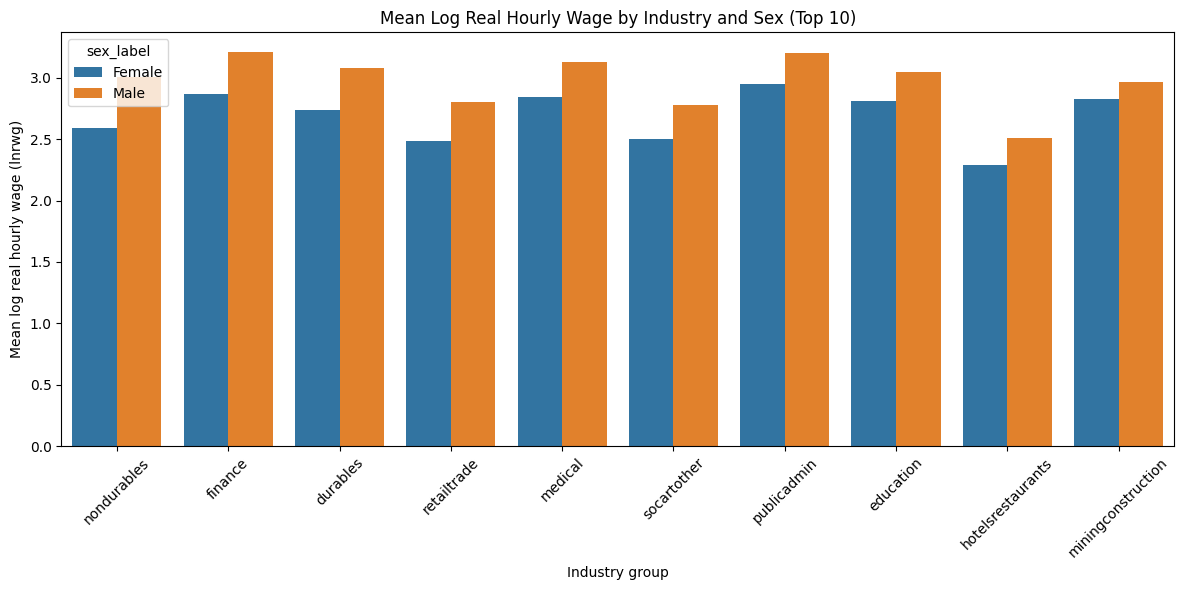

In [39]:
ind_order = (
    ind_gap.sort_values("gap_pct", ascending=False).index
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=ind_sex_mean,
    x="ind",
    y="lnrwg",
    hue="sex_label",
    order=ind_order
)

plt.title("Mean Log Real Hourly Wage by Industry and Sex (Top 10)")
plt.xlabel("Industry group")
plt.ylabel("Mean log real hourly wage (lnrwg)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Key Analysis:

Across the ten largest industry groups, men earn more than women in all cases.
- The smallest gaps occur in mining/construction (~15%), and remain moderate in hotels/restaurants and education (~25%).
- Gaps rise to roughly one-third in medical (~33%), other services (~32%), public administration (~29%), and retail trade (~38%).
- The largest disparities appear in nondurables (~51%) and finance (~41%).
- The bar chart shows this pattern clearly: for every industry, the male bar sits above the female bar, with especially pronounced separation in nondurables, finance and retail trade.

## 6.5) Correlation Matrix

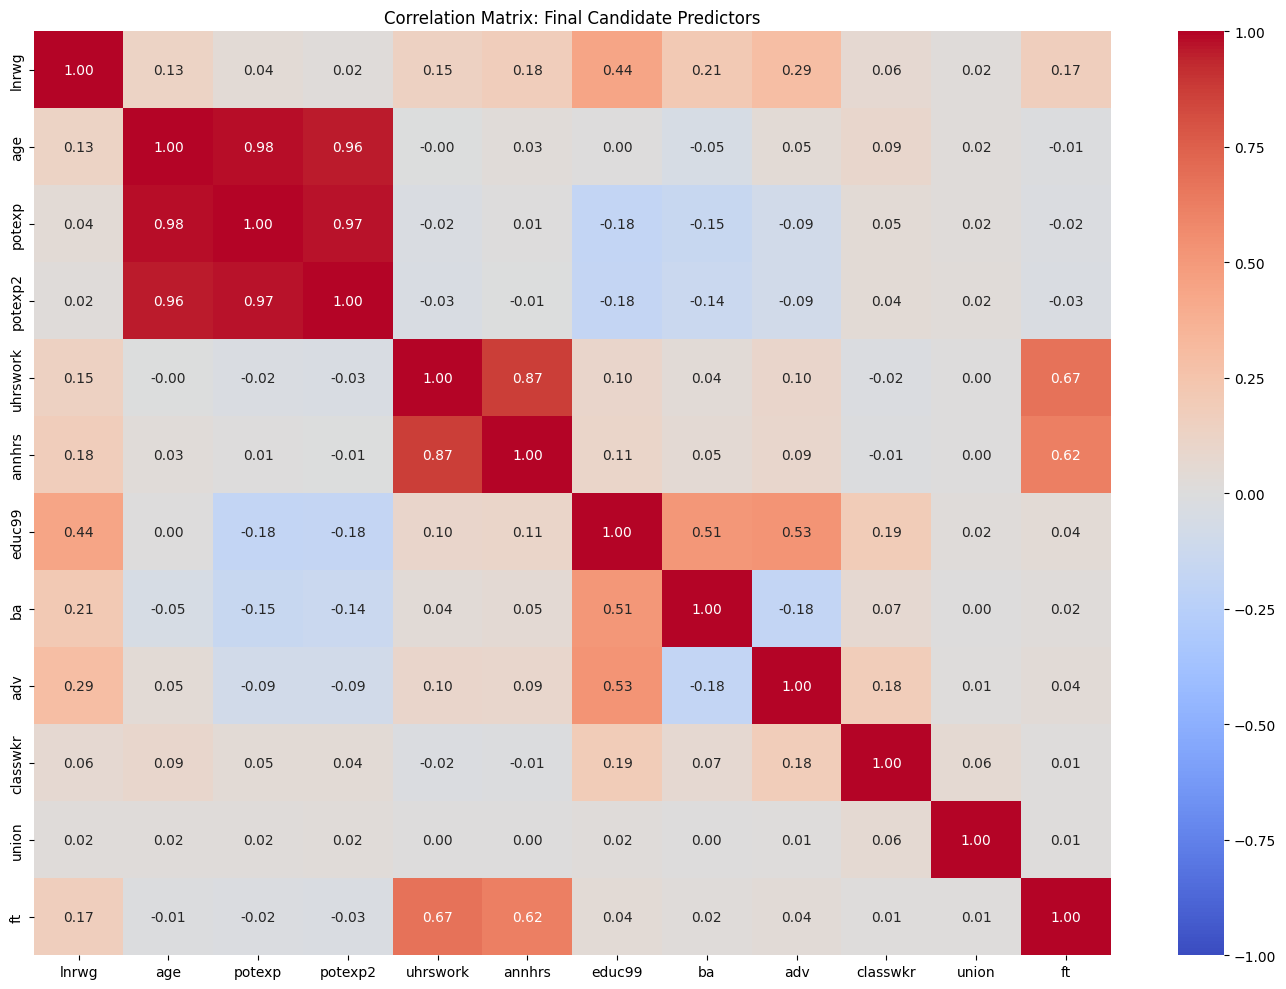

In [40]:
corr_cols = ["lnrwg", "age", "potexp", "potexp2", "uhrswork", "annhrs", "educ99", "ba", "adv", "classwkr", "union", "ft",]

corr_df = df_eda[corr_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    fmt=".2f"
)
plt.title("Correlation Matrix: Final Candidate Predictors")
plt.tight_layout()
plt.show()

#### Key Analysis:

The matrix focuses only on continuous, interpretable variables (i.e. where correlation is meaningful). Occupation and industry dummies were excluded.

The matrix shows:

1) Age, potential experience, and its square are almost perfectly correlated (≈0.97–0.99). This is expected: `potexp` and `potexp2` capture the nonlinear earnings profile and are both required.

2) Hours variables (`uhrswork`, `annhrs`) correlate strongly (0.87) because weekly hours drive annual hours. They measure related but distinct aspects of labour supply so both are kept.

3) Education variables (`educ99`, `ba`, `adv`) correlate moderately (0.51–0.53) because BA and ADV are specific degree dummies nested within the broader education variable. As seen previously, they capture different aspects and are therefore kept.

Overall, the selection reveals no multicollinearity severe enough to threaten OLS inference.

# 7) Temporal Patterns

Before deciding how to split the data into training and test sets, we check whether wages and work patterns change meaningfully over time. If earlier years look similar to the final year (2013), then training on the past and testing on the last year is both safe and realistic.

## 7.1) Year-level summary: size, wages, hours

In [41]:
year_stats = (
    df_eda.groupby("year")
    .agg(
        n_rows=("lnrwg", "size"),
        mean_realhrwage=("realhrwage", "mean"),
        mean_lnrwg=("lnrwg", "mean"),
        mean_uhrswork=("uhrswork", "mean"),
        mean_annhrs=("annhrs", "mean"), 
    )
    .reset_index()
)

print("Year-level summary: sample size, wages, and hours")
display(year_stats)

Year-level summary: sample size, wages, and hours


,year,n_rows,mean_realhrwage,mean_lnrwg,mean_uhrswork,mean_annhrs
0,1981,42379,18.199893,2.729362,40.019562,1942.961018
1,1990,45033,18.874061,2.755517,40.418360,1984.984101
2,1999,37144,20.502592,2.826690,41.106154,2043.437594
3,2007,56467,23.221978,2.927273,40.967060,2047.625179
4,2009,55617,28.990501,2.941718,40.670299,2035.670460
5,2011,53857,23.425680,2.938042,40.302765,2003.053104
6,2013,53790,24.381761,2.936589,40.547444,2022.045362


## 7.2) Mean log wage over time (overall)

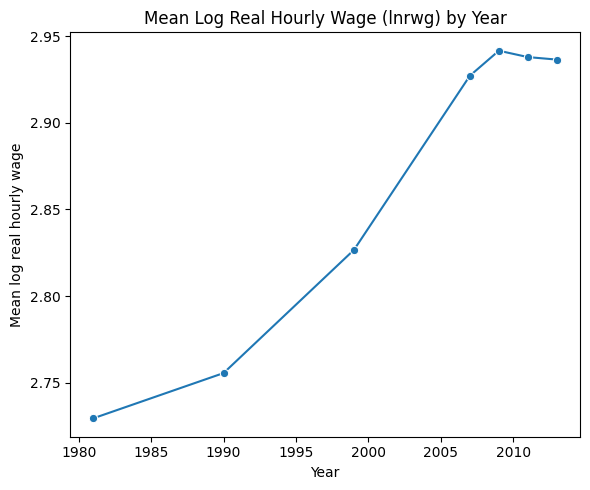

In [42]:
plt.figure(figsize=(6,5))
sns.lineplot(
    data=year_stats,
    x="year",
    y="mean_lnrwg",
    marker="o"
)

plt.title("Mean Log Real Hourly Wage (lnrwg) by Year")
plt.xlabel("Year")
plt.ylabel("Mean log real hourly wage")
plt.tight_layout()
plt.show()

## 7.3) Mean log wage over time by sex

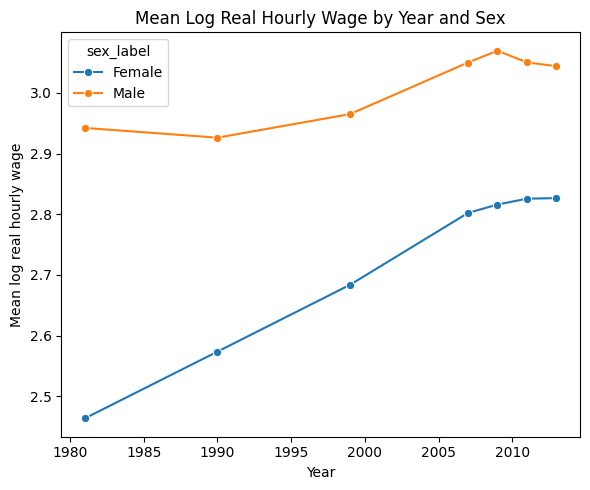

In [43]:
year_sex_stats = (
    df_eda.groupby(["year", "sex_label"])["lnrwg"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 5))
sns.lineplot(
    data=year_sex_stats,
    x="year",
    y="lnrwg",
    hue="sex_label",
    marker="o"
)
plt.title("Mean Log Real Hourly Wage by Year and Sex")
plt.xlabel("Year")
plt.ylabel("Mean log real hourly wage")
plt.tight_layout()
plt.show()


#### Overall wage trends: 

Mean log real hourly wages rise steadily from 1981 to 2013. There is a small softening after around 2007 consistent with the recession repercussions, but nothing resembling a structural break or change in the wage pattern.


#### Wages by gender:

Gender differences follow the same trajectory.


#### Hours worked:

Weekly and annual hours remain consistently close to full-time across all years.


#### Implications:

Because wages, gender differences and hours all evolve consistently over time, and the small post-2007 dip is shared by both groups, the final year behaves normally.

Therefore:

### ```Given stable patterns, the latest year (2013) is used as the test set.```

# 8) Data Quality Decisions & Exclusions

This section does not introduce new analysis, it simply states the decisions that will define the modeling cohort.


####    - Missingness.

Variables with unusable missingness (citizen, nativity) were removed earlier. Education missingness is kept as-is.


####    - Outliers.

All observations are retained, relying on "lnrwg" to stabilise the extreme right tail.


####    - Rare categories.

Some occupation and industry groups have very small counts. They are not removed here but will be filtered in the cohort rules.

# 9) Cohort Rules & Predictor Set (Hand-off to SQL)

To move from exploration to modelling, the analysis defines (1) who enters the modelling cohort and (2) which variables the model will learn from. These rules will be implemented in ```vw_model_cohort``` in SQL.

### 9.1) Cohort definition (who is included)

A worker enters the modelling cohort if and only if:


1. **Wage** fields are valid (```lnrwg``` must be > 0 and non-missing).

2. **Labour supply** fields exist: 10 < ```uhrswork``` <= 100  and  ```annhrs``` >= uhrswork * 50.

3. **Human capital** variables must be present (```educ99```, ```ba```, ```adv```,```potexp```, ```potexp2```).

4. Exactly one occupation and one industry group is flagged.

5. **Age** is between 25 and 64


#### `Race` and `marital status` are excluded from the cohort.
#### They were explored descriptively in the EDA, but are not used as predictors so as to prevent the model from reproducing historical patterns of demographic discrimination.

If any of these points is not met, the row is excluded.

### 9.2) Final cohort selection

After applying the rules above, the modelling table contains:

  - **Wage variables**: ```lnrwg```

  - **Human capital:** ```educ99```, ```ba```, ```adv```, ```potexp```, ```potexp2```

  - **Demographics:** ```sex```, ```age```

  - **Job structure:** ```classwkr```, ```union```, ```ft```, ```uhrswork```, ```annhrs```

  - **Occupation dummies:** all 22

  - **Industry dummies:** all 15

  - **Time variable:** ```year```

# 10) EDA conclusions (summary for modelling)

The EDA shows that the gender pay gap is large, persistent, and stable across all years, occupations, industries, and education levels. Wages and hours follow smooth trends through time, and the final year (2013) behaves exactly like the preceding years, making it a reliable and realistic test set.

The analysis also confirms that the key wage determinants (education, experience, age, job structure, hours, and the occupation/industry dummies) can be included together, without posing multicollinearity problems. 

Finally, the EDA shows that the dataset is internally consistent, free of impossible values, and dominated by full-time, prime-age workers, which makes the data suitable for a clear modelling cohort.

With this foundation in place, we can now move on to building the cohort view and fitting the wage models.

### End of notebook 2